# verify the virtual environment

In [1]:
"""
Run the following commands to check the installation, 
the model is verified to work if the version is perfectly match, 
otherwise it may fail
"""

# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version


# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

import mmcv
print(mmcv.__version__)

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

/bin/bash: nvcc: command not found
gcc (Ubuntu 7.5.0-6ubuntu2) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

1.7.0 True
1.3.4
2.11.0
11.0
GCC 7.3


In [2]:
# necessary package to import
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from PIL import Image, ImageDraw, ImageFont
from distinctipy import distinctipy
import json


# pick 30 visually distinct colors for better visuallization experience
colors = distinctipy.get_colors(30)

# DEMO for simulated plot image

## step 1. run the axis alignment module to detect and recognize the ticks, find the region of interest
![](ill_plot.png)

In [3]:
from src.axis_alignment.utils import dict2class, AxisAlignment

In [4]:
opt = {
    # region detection
    "config_file": "./checkpoints/axis_alignment/fcos_x101_64x4d_fpn_gn-head_mstrain_640-800_2x_coco.py",
    "checkpoint_file": "./checkpoints/axis_alignment/epoch_200.pth",
    "refinement": True,
    # tick detection
    "cuda": True,
    "canvas_size": 1280,
    "mag_ratio": 1.5,
    "poly": False,
    "text_threshold": 0.7,
    "low_text": 0.4,
    "link_threshold": 0.7,
    "show_time": False,
    "refine": True,
    "trained_model": './checkpoints/axis_alignment/craft_mlt_25k.pth',
    "refiner_model": './checkpoints/axis_alignment/craft_refiner_CTW1500.pth',
    # tick recognition
    "workers": 4,
    "saved_model": "./checkpoints/axis_alignment/TPS-ResNet-BiLSTM-Attn.pth",
    "batch_max_length": 25,
    "imgH": 32,
    "imgW": 100,
    "rgb": False,
    "character": "0123456789abcdefghijklmnopqrstuvwxyz",
    "sensitive": False,
    "PAD": True,
    "Transformation": "TPS",
    "FeatureExtraction": "ResNet",
    "SequenceModeling": "BiLSTM",
    "Prediction": "Attn",
    "num_fiducial": 20,
    "input_channel": 1,
    "output_channel": 512,
    "hidden_size": 256,
    
}  
    
# initialize the axis alignment module
axis_alignment = AxisAlignment(opt)

build plot detector ...
Use load_from_local loader
model input parameters 32 100 20 1 512 256 38 25 TPS ResNet BiLSTM Attn
loading pretrained model from ./checkpoints/axis_alignment/TPS-ResNet-BiLSTM-Attn.pth


In [5]:
# load all images in the given folder
path = "./example_plot_images/"
axis_alignment.load_data(path)
len(axis_alignment.imglist)

1

In [6]:
# save region of interest
region_path = "./data/regions"
axis_alignment.crop(region_path)


  0%|          | 0/1 [00:00<?, ?it/s]/home/weixin/anaconda3/envs/tmp_env/lib/python3.8/site-packages/mmdet/datasets/utils.py:64: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


## step 2. run the plot data extraction module to detect plot lines

In [7]:
from src.plot_data_extraction.plot_digitizer import PlotDigitizer
from src.plot_data_extraction.SpatialEmbeddings.src.utils import transforms as my_transforms
from src.plot_data_extraction.evaluation import PlotEvaluator
from src.plot_data_extraction.utils import GenerateTestData, dict2class, Segmap2Lines


# convert the format of the plot region to fit the requirement of the plot data extraction module
GenerateTestData("./data/regions/", 
                 "./data/input_plot_extraction")

In [8]:
opt = {
    "cuda": True,
    "display": False,
    "save": True,
    "save_dir": "./exp/",
    "root": "./data/input_plot_extraction/leftImg8bit/",
    "data_type": "test",
    "mode": "raman_xanes",
    "num_workers": 6,
    "checkpoint_path": "./checkpoints/plot_data_extraction/checkpoint_0999.pth",

    
    "dataset": {
        'name': 'cityscapes',
        'kwargs': {
            'root_dir': "./data/input_plot_extraction",
            'type': 'test',
            'transform': my_transforms.get_transform([
                {
                    "name": "CustomResizePad",
                    "opts": {
                        'keys': ('image', 'instance','label'),
                        "is_test": True,
                    },
                },
                {
                    'name': 'ToTensor',
                    'opts': {
                        'keys': ('image', 'instance', 'label'),
                        'type': (torch.FloatTensor, torch.ByteTensor, torch.ByteTensor),
                    }
                },
                {
                    'name': 'Normalize',
                    'opts': {
                        'keys': ('image'),
                        'p': -1,
                    }
                },
            ]),
        }
    },
    
    "model": {
        'name': 'branched_erfnet',
        'kwargs': {
            'num_classes': [3, 1],
        }
    }
}

# initialize the plot data extraction module
plot_digitizer = PlotDigitizer()
plot_digitizer.load_seg("spatialembedding", opt)
len(plot_digitizer.instance_seg)

Creating branched erfnet with [3, 1] classes
Resuming model from ./checkpoints/plot_data_extraction/checkpoint_0999.pth
Cityscapes Dataset created


1

In [9]:
"""
grid search for the best parameter setting:
 - match_threshold (i.e. change the coefficient for different losses)
 - start position
"""
def Run(plot_digitizer, img_id):
    plot_digitizer.predict_from_ins_seg(img_id)
    ins_map = plot_digitizer.result_dict["visual"]["ins_map"]
    img_gray = plot_digitizer.result_dict["visual"]["img_gray"]
    img_rgb = plot_digitizer.result_dict["visual"]["img_rgb"]
    seg_map = plot_digitizer.result_dict["visual"]["seg_map"]
    seg_plots = Segmap2Lines(ins_map)
    plot_digitizer.find_init_posi()
    plot_evaluator = PlotEvaluator(img_rgb, img_gray, seg_map)
    match_thresholds = [0.8,0.85,0.9,0.95,0.97,0.99]
    start_ids = plot_digitizer.result_dict["data"]["start_ids"]
    scores, param_space, line_sets = plot_evaluator.param_search(match_thresholds, start_ids)
    mean_score = np.mean(scores, axis=1)
    s, m = param_space[np.argmax(mean_score)]
    line_set = line_sets[np.argmax(mean_score)]
    result = {}
    result["img_name"] = plot_digitizer.img_name
    result["start_posi"] = s
    result["match_threshold"] = m
    result["pred_line_set"] = line_set
    result["seg_line_set"] = seg_plots
    result["visual"] = [img_rgb, seg_map, ins_map]
    return result

In [10]:
# generate the result for the test image
img, plot_bbox, results, results_all = axis_alignment.run(0)
result = Run(plot_digitizer, 0)

/home/weixin/Documents/tmp/Plot2Spec/src/axis_alignment/tick_detection/craft_utils.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  polys = np.array(polys)


estimated linewidth: 4.0
estimated num of plots: 4
num of start position: 252


## result evaluation

Text(0.5, 1.0, 'model output')

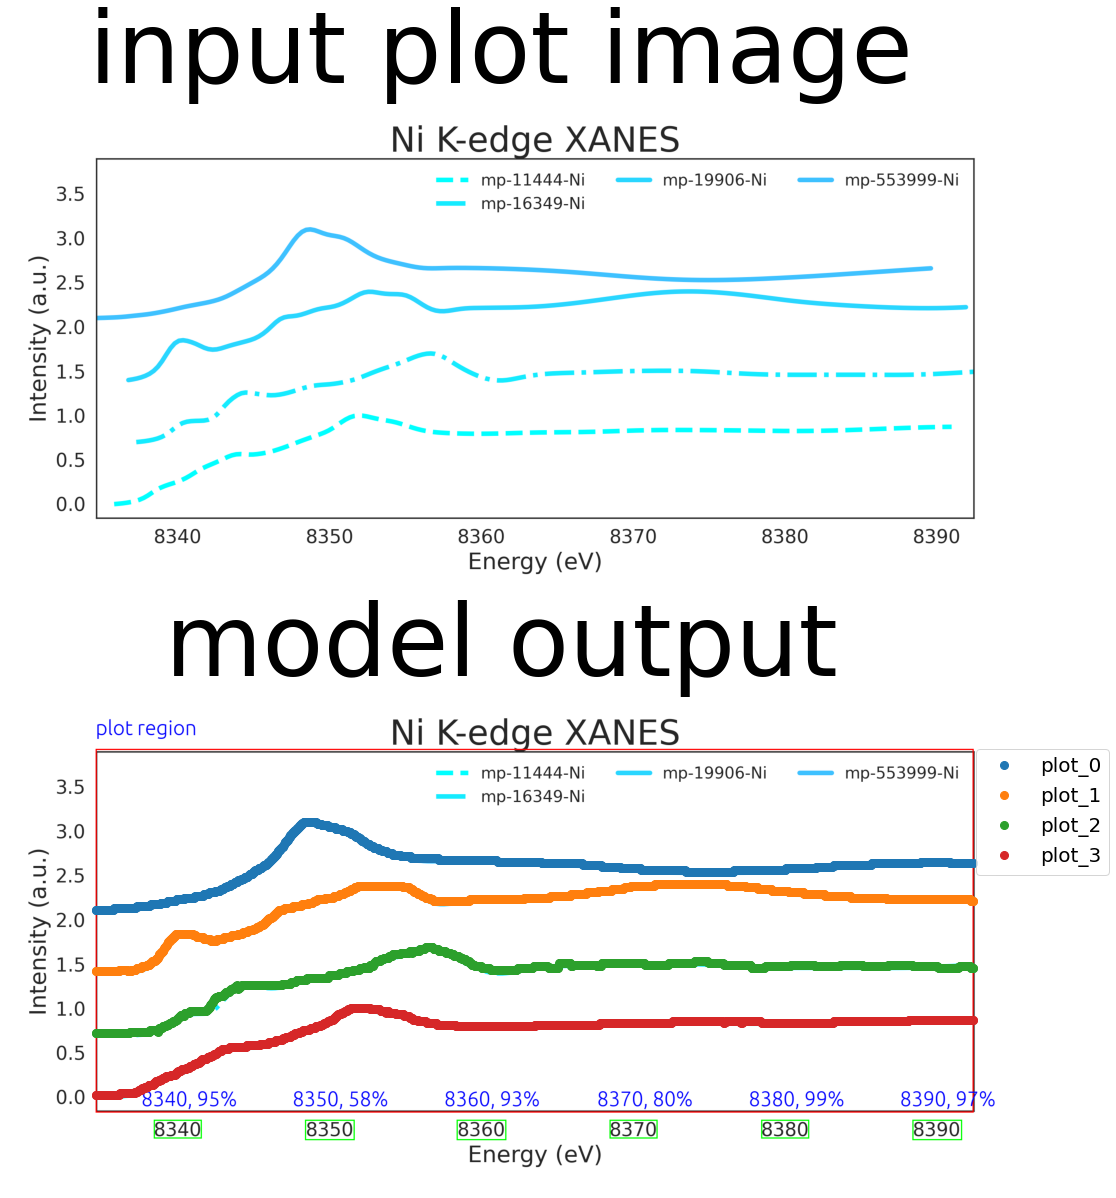

In [11]:
plt.figure(figsize=(20,20))

img_raw = Image.open("./example_plot_images/simu.png").convert("RGB")
plt.subplot(2,1,1)
plt.imshow(img_raw)
plt.axis("off")
plt.title("input plot image", fontsize=100)


plt.subplot(2,1,2)
img_draw = img_raw.copy()
draw = ImageDraw.Draw(img_draw)
draw.rectangle(list(plot_bbox), outline=(255,0,0), width=3)
try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/ubuntu/Ubuntu-L.ttf", size=50)
except:
    font = ImageFont.load_default()
text_position = list(plot_bbox)[:2]
text_position[1] -= 80
draw.text(text_position, font=font, fill=(0,0,255), text="plot region", align ="left") 

for idx, tick in enumerate(results):
    draw.rectangle(list(tick[2]), outline=(0,255,0), width=3)
    text_position = list(tick[2])[:2]
    text_position[1] -= 80
    text_position[0] -= 30
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/ubuntu/Ubuntu-L.ttf", size=50)
    except:
        font = ImageFont.load_default()
    draw.text(text_position, font=font, fill=(0,0,255), text="{}, {}%".format(tick[0], round(tick[1]*100)), align ="left") 


plt.imshow(img_draw)

x_bias, y_bias = list(plot_bbox)[:2]
x_min, y_min, x_max, y_max = int(list(plot_bbox)[0]), list(plot_bbox)[1], int(list(plot_bbox)[2]), list(plot_bbox)[3]
x_count = x_max-x_min+1
norm_ts = np.linspace(0,x_max-x_min, x_count)
y_resize_ratio = (y_max-y_min)/result["visual"][0].shape[0]

plot_ts, plot_lines = result["pred_line_set"]["plot"]
norm_ts_pred = np.linspace(min(plot_ts), max(plot_ts), x_count)

conf_ts, conf_lines = result["pred_line_set"]["conf"]

for line_id in range(plot_lines.shape[1]):
    plot_line_norm = np.interp(norm_ts_pred, plot_ts, plot_lines[:,line_id])
#     confidence map, part of the reconstructed plot lines is 
#     conf_line_norm = np.interp(norm_ts_pred, conf_ts, conf_lines[:,line_id])
#     ts, vs = [], []
#     for idx, v in enumerate(norm_ts):
#         if conf_line_norm[idx] > 0.5:
#             ts.append(v+x_bias)
#             vs.append(plot_line_norm[idx]*y_resize_ratio+y_bias)
#     plt.plot(ts, vs, "o", markersize=8, label="plot_{}".format(line_id))
    plt.plot(norm_ts+x_bias, plot_line_norm*y_resize_ratio+y_bias, "o", markersize=8, label="plot_{}".format(line_id))


# gt_annot = np.load("./example_plot_images/sample.npy", allow_pickle=True)
# for line_id in range(len(gt_annot)-2):
#     gt_plot_ts, gt_plot_line = gt_annot[line_id][3:]
#     plt.plot(np.array(gt_plot_ts)+x_bias, np.array(gt_plot_line)+y_bias, "o", markersize=8)


plt.legend(fontsize=20, bbox_to_anchor=(0.97, 0.915))
plt.axis("off")
plt.title("model output", fontsize=100)

